# Quantum Error Correction Project
## Philippe Noël, Alaisha Sharma, Nicolas Weninger
### File #1: 3-qubits code

In [129]:
import os
import sys

from qutip import *

from qiskit import QuantumProgram
import Qconfig
from qiskit.tools.visualization import plot_histogram, plot_state
from qiskit.backends import local_backends, remote_backends
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

assert sys.version_info >= (3,5), "Only Python 3.5 or greater supported."

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image

#### Overview of the 3-qubit code (for bit flips)
Source: https://arxiv.org/pdf/0905.2794.pdf

<img src="img/3_qubits_circuit.png">

<img src="img/3_qubits_code_ancilla_table.png">

We encode the state of the logical qubit as shown above, and then detect for a bit flip error using the ancillary qubits. This error detection scheme assumes that errors only occur after encoding (in other words, the encoding is perfect) and that any error is a single bit flip on exactly one of the non-ancillary qubits. 

### 1. Run the theoretical simulation without errors with a local quantum simulator as a control experiment.

Measurement after simulation gate without errors (control):


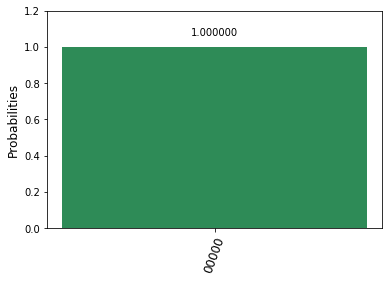

In [130]:
# Run circuit without any errors on local quantum simulator
qp1 = QuantumProgram()

# 3 qubits plus 2 ancillary qubits
n = 5

# Quantum register
q = qp1.create_quantum_register("q", n)
# Classical register
c = qp1.create_classical_register("c", n) 

# SimControl3 circuit
sim_control3 = qp1.create_circuit("SimControl3", [q], [c])

## ADD GATES

# Encode state
sim_control3.cx(q[0], q[1]) 
sim_control3.cx(q[1], q[2]) 

# Error detection
sim_control3.cx(q[0], q[3]) 
sim_control3.cx(q[1], q[3]) 
sim_control3.cx(q[0], q[4]) 
sim_control3.cx(q[2], q[4]) 

# Add measurement operation
sim_control3.measure(q[3], c[3])
sim_control3.measure(q[4], c[4])

# Execute circuit
results = qp1.execute("SimControl3")

# Plot measurement results 
print("Measurement after simulation gate without errors (control):")
plot_histogram(results.get_counts("SimControl3"))

### 2. Run the theoretical simulation with a local quantum simulator and detect single bit flips.

This circuit is identical to the one above, except we artifically introduce a bit flip error on each of the three non-ancillary qubits one at a time to show that the error detection is working correctly. An error on the first qubit will flip both ancillary qubits; an error on the second qubit will flip only the first ancillary qubit; and an error on the third qubit will flip only the second ancillary qubit.

Measurement after gate detecting bit flip error on qubit 0 :


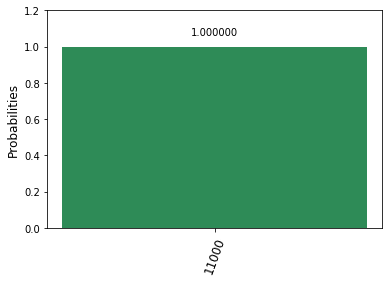

Measurement after gate detecting bit flip error on qubit 1 :


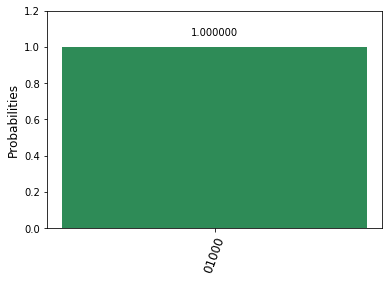

Measurement after gate detecting bit flip error on qubit 2 :


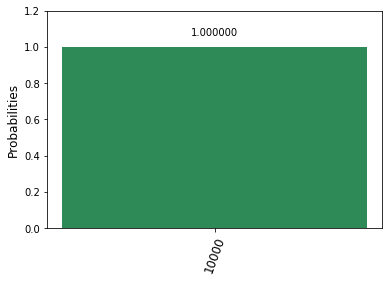

In [131]:
# 3 qubits plus 2 ancillary qubits
n = 5

for val in [0, 1, 2]:
    # Run circuit to detect single bit flip error on quantum simulator
    qp2eb = QuantumProgram()
    
    # Quantum register
    q = qp2eb.create_quantum_register("q", n)
    # Classical register
    c = qp2eb.create_classical_register("c", n) 

    # SimErrorBit3 circuit
    sim_err_bit3 = qp2eb.create_circuit("SimErrorBit3", [q], [c])

    ## ADD GATES
    
    # Encode state
    sim_err_bit3.cx(q[0], q[1]) 
    sim_err_bit3.cx(q[0], q[2]) 
    
    # Introduce bit flip error
    sim_err_bit3.x(q[val])
    
    # Error detection
    sim_err_bit3.cx(q[0], q[3]) 
    sim_err_bit3.cx(q[1], q[3]) 
    sim_err_bit3.cx(q[0], q[4]) 
    sim_err_bit3.cx(q[2], q[4]) 

    # Add measurement operation
    sim_err_bit3.measure(q[3], c[3])
    sim_err_bit3.measure(q[4], c[4])

    # Execute circuit
    results = qp2eb.execute("SimErrorBit3")

    # Plot measurement results 
    print("Measurement after gate detecting bit flip error on qubit", val, ":")
    plot_histogram(results.get_counts("SimErrorBit3"))

### 3. Run the theoretical simulation with a local quantum simulator and correct for single bit flips.

Now in addition to detecting single bit flip errors, this circuit adds a set of gates that apply a corrective operation. Based on which ancillary qubits were flipped, we theoretically know exactly on which qubit the error occured. Therefore we can use CNOT gates to correct the second and third qubits (because only one ancillary qubit is flipped in either case) and double CNOT gates to correct the first qubit (because both ancillary qubits are flipped in this case).

Measurement after gate correcting bit flip error on qubit 0 :


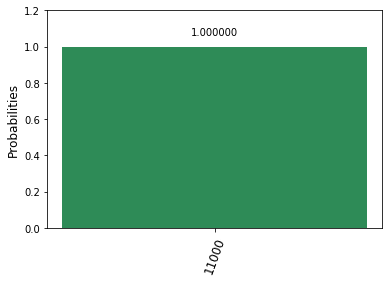

Measurement after gate correcting bit flip error on qubit 1 :


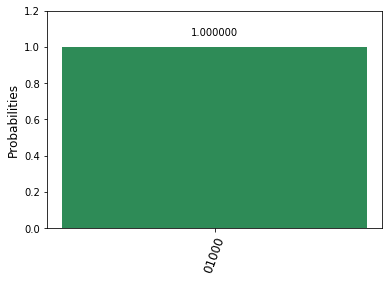

Measurement after gate correcting bit flip error on qubit 2 :


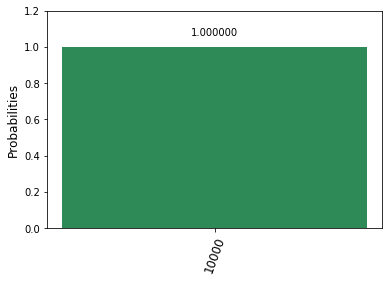

In [132]:
# 3 qubits plus 2 ancillary qubits
n = 5

for val in [0, 1, 2]:
    # Run circuit to correct single bit flip error on quantum simulator
    qp2cb = QuantumProgram()
    
    # Quantum register
    q = qp2cb.create_quantum_register("q", n)
    # Classical register
    c = qp2cb.create_classical_register("c", n) 
    
    # SimCorrectBit3 circuit
    sim_cor_bit3 = qp2cb.create_circuit("SimCorrectBit3", [q], [c])

    ## ADD GATES
    
    # Encode state
    sim_cor_bit3.cx(q[0], q[1]) 
    sim_cor_bit3.cx(q[0], q[2]) 
    
    # Introduce bit flip error
    sim_cor_bit3.x(q[val])
    
    # Error detection
    sim_cor_bit3.cx(q[0], q[3]) 
    sim_cor_bit3.cx(q[1], q[3]) 
    sim_cor_bit3.cx(q[0], q[4]) 
    sim_cor_bit3.cx(q[2], q[4]) 
    
    # Error correction
    sim_cor_bit3.ccx(q[3], q[4], q[0])
    sim_cor_bit3.ccx(q[3], q[4], q[1])
    sim_cor_bit3.ccx(q[3], q[4], q[2])
    sim_cor_bit3.cx(q[3], q[1]) 
    sim_cor_bit3.cx(q[4], q[2]) 
    
    # Add measurement operation
    sim_cor_bit3.measure(q[0], c[0])
    sim_cor_bit3.measure(q[1], c[1])
    sim_cor_bit3.measure(q[2], c[2])
    sim_cor_bit3.measure(q[3], c[3])
    sim_cor_bit3.measure(q[4], c[4])

    # Execute circuit
    results = qp2cb.execute("SimCorrectBit3")

    # Plot measurement results 
    print("Measurement after gate correcting bit flip error on qubit", val, ":")
    plot_histogram(results.get_counts("SimCorrectBit3"))

#### Overview of the 3-qubit code (for phase flips)
Source: http://quantum.phys.cmu.edu/QCQI/qitd213.pdf

<img src="img/3_qubits_decoder.png">

### 4. Run the theoretical simulation with a local quantum simulator and detect single phase flips.

We encode the state of the logical qubit as shown above, except apply a Hadamard gate first to create an arbitrary state. This is because a phase flip applied to the $|0 \rangle$ state yields the $|0 \rangle$ state again so it would be a trivial error. We then detect for a phase flip error using the ancillary qubits (a phase flip in the binary basis is equivalent to a bit flip in the Hadamard basis). Again this error detection scheme assumes that errors only occur after encoding (in other words, the encoding is perfect) and that any error is a single phase flip on exactly one of the non-ancillary qubits. 

Measurement after gate detecting phase flip error on qubit 0 :


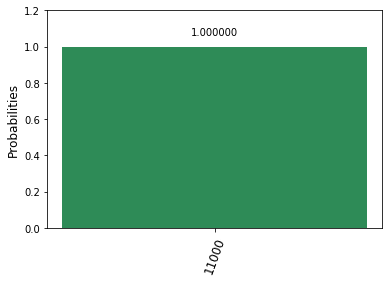

Measurement after gate detecting phase flip error on qubit 1 :


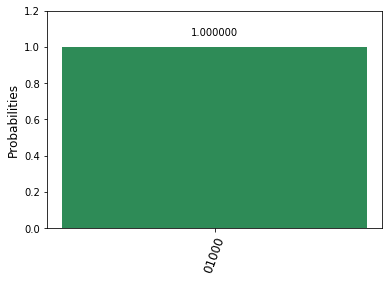

Measurement after gate detecting phase flip error on qubit 2 :


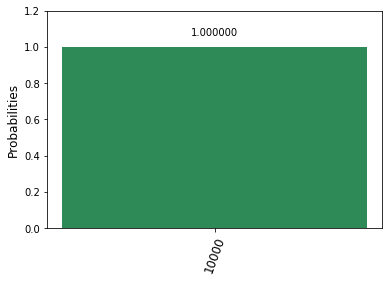

In [133]:
# 3 qubits plus 2 ancillary qubits
n = 5

for val in [0, 1, 2]:
    # Run circuit to detect single phase flip error on quantum simulator
    qp2ep = QuantumProgram()

    # Quantum register
    q = qp2ep.create_quantum_register("q", n)
    # Classical register
    c = qp2ep.create_classical_register("c", n) 

    # SimErrorPhase3 circuit
    sim_err_phase3 = qp2ep.create_circuit("SimErrorPhase3", [q], [c])
    
    ## ADD GATES
    
    # Hadamard basis
    sim_err_phase3.h(q[0])
    
    # Encode state
    sim_err_phase3.cx(q[0], q[1]) 
    sim_err_phase3.cx(q[0], q[2])
    
    # Hadamard basis
    sim_err_phase3.h(q[0])
    sim_err_phase3.h(q[1])
    sim_err_phase3.h(q[2])
    
    # Introduce phase flip error
    sim_err_phase3.z(q[val])
    
    # Hadamard basis
    sim_err_phase3.h(q[0])
    sim_err_phase3.h(q[1])
    sim_err_phase3.h(q[2])
    
    # Error detection
    sim_err_phase3.cx(q[0], q[3]) 
    sim_err_phase3.cx(q[1], q[3]) 
    sim_err_phase3.cx(q[0], q[4]) 
    sim_err_phase3.cx(q[2], q[4]) 

    # Add measurement operation
    sim_err_phase3.measure(q[3], c[3])
    sim_err_phase3.measure(q[4], c[4])

    # Execute circuit
    results = qp2ep.execute("SimErrorPhase3")

    # Plot measurement results 
    print("Measurement after gate detecting phase flip error on qubit", val, ":")
    plot_histogram(results.get_counts("SimErrorPhase3"))

### 5. Run the theoretical simulation with a local quantum simulator and correct for single phase flips.

Now in addition to detecting single bit flip errors, this circuit adds a set of gates that apply a corrective operation. Instead of changing to the Hadamard basis and then applying a bit flip (X gate) we just apply a phase flip in the binary basis (Z gate), so we can then use CNOT gates to correct the error. Based on which ancillary qubits were flipped, we theoretically know exactly on which qubit the error occured. The error correction process here is identical to the bit flip circuit, except we wrap each CNOT gate in Hadamard gates. This makes the gates behave like controlled Z gates.

Measurement after gate correcting phase flip error on qubit 0 :


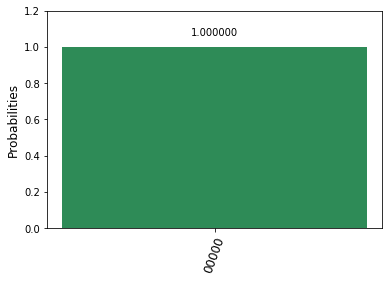

Measurement after gate correcting phase flip error on qubit 1 :


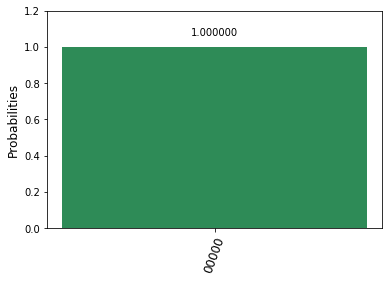

Measurement after gate correcting phase flip error on qubit 2 :


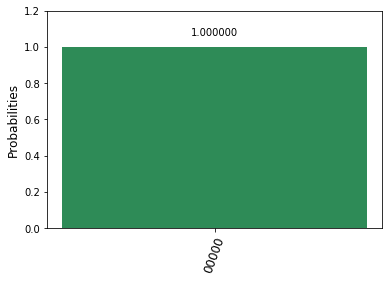

In [134]:
# 3 qubits plus 2 ancillary qubits
n = 5

for val in [0, 1, 2]:
    # Run circuit to detect single phase flip error on quantum simulator
    qp2cp = QuantumProgram()

    # Quantum register
    q = qp2cp.create_quantum_register("q", n)
    # Classical register
    c = qp2cp.create_classical_register("c", n) 

    # SimCorrectPhase3 circuit
    sim_cor_phase3 = qp2cp.create_circuit("SimCorrectPhase3", [q], [c])
    
    ## ADD GATES
    
    # Encode state
    sim_cor_phase3.cx(q[0], q[1]) 
    sim_cor_phase3.cx(q[1], q[2])

    # Introduce phase flip error
    sim_cor_phase3.z(q[val]) 
    
    # Error detection
    sim_cor_phase3.cz(q[0], q[3]) 
    sim_cor_phase3.cz(q[1], q[3]) 
    sim_cor_phase3.cz(q[0], q[4]) 
    sim_cor_phase3.cz(q[2], q[4]) 
    
    # Error correction
    sim_cor_phase3.h(q[0])
    sim_cor_phase3.ccx(q[3], q[4], q[0])
    sim_cor_phase3.h(q[0])
    sim_cor_phase3.h(q[1])
    sim_cor_phase3.ccx(q[3], q[4], q[1])
    sim_cor_phase3.h(q[1])
    sim_cor_phase3.h(q[2])
    sim_cor_phase3.ccx(q[3], q[4], q[2])
    sim_cor_phase3.h(q[2])
    sim_cor_phase3.cz(q[3], q[1]) 
    sim_cor_phase3.cz(q[4], q[2])
    
    # Add measurement operation
    sim_cor_phase3.measure(q[0], c[0])
    sim_cor_phase3.measure(q[1], c[1])
    sim_cor_phase3.measure(q[2], c[2])
    sim_cor_phase3.measure(q[3], c[3])
    sim_cor_phase3.measure(q[4], c[4])

    # Execute circuit
    results = qp2cp.execute("SimCorrectPhase3")

    # Plot measurement results 
    print("Measurement after gate correcting phase flip error on qubit", val, ":")
    plot_histogram(results.get_counts("SimCorrectPhase3"))

In [135]:
# initialize API to run on IBMQ
qp1.set_api(Qconfig.APItoken, Qconfig.config["url"])
display(local_backends())
display(remote_backends())

/anaconda3/lib/python3.6/site-packages/qiskit/_quantumprogram.py:707: DeprecationWarning: set_api() will be deprecated in upcoming versions (>0.5.0). Using the API object instead is recommended.
  "Using the API object instead is recommended.", DeprecationWarning)


['local_qasm_simulator',
 'local_clifford_simulator',
 'local_qiskit_simulator',
 'local_sympy_qasm_simulator',
 'local_sympy_unitary_simulator',
 'local_unitary_simulator']

['ibmqx_hpc_qasm_simulator',
 'ibmqx4',
 'ibmqx5',
 'ibmqx2',
 'ibmqx_qasm_simulator']

<img src="img/3_qubits_code_error_locations.png">

Unlike with the theoretical simulation, here we cannot assume that the encoding of states is perfect or that the only errors that occur are either single bit flip or single phase flip errors on the non-ancillary qubits. The diagram above shows some of the possibilites for how the error detection starts the break down when multiple errors occur. Here we can see the difference between the results of the theoretical simulations and of the simulations on the IBMQ backend. On the IBMQ backend it is likely that other types of errors occurred, both during encoding and afterwards.

### 6. Run the circuit without errors on the IBMQ backend as a control experiment.

This circuit, without any errors introduced, is probably the best example of how running a circuit on the IBMQ backend creates the possibility of introducing errors that we did not artificially add to the circuit. From the control circuit earlier, we know that the resulting state should be $|00000 \rangle$ with probability 1 because the initial state is $|0 \rangle$ and no errors are introduced. This means that the three non-ancillary qubits should be 0 and the ancillary should also be 0 because neither was flipped during error detection. However we find that after measuring just the ancillary qubits, the histogram shows that the assumptions made during the theoretical simulation break down because of other "quantum noise" on the IBMQ backend.

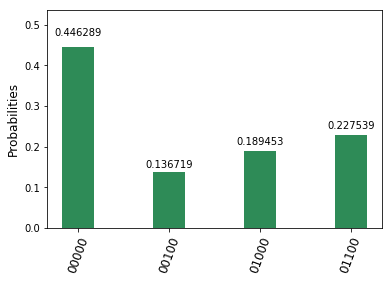

In [136]:
# Run circuit without any errors on IBMQ backend
qp3 = QuantumProgram()

# 3 qubits plus 2 ancillary qubits
n = 5

# Quantum register
q = qp3.create_quantum_register("q", n)
# Classical register
c = qp3.create_classical_register("c", n) 

# SimControl3 circuit
imbq_control3 = qp3.create_circuit("IBMQControl3", [q], [c])

## ADD GATES

# Encode state
imbq_control3.cx(q[0], q[1]) 
imbq_control3.cx(q[1], q[2]) 

# Error detection
imbq_control3.cx(q[0], q[3]) 
imbq_control3.cx(q[1], q[3]) 
imbq_control3.cx(q[0], q[4]) 
imbq_control3.cx(q[2], q[4]) 

# Add measurement operation
imbq_control3.measure(q[3], c[3])
imbq_control3.measure(q[4], c[4])

# Set parameters
backend = 'ibmqx4'   
circuits = ['IBMQControl3']  
shots = 1024           
max_credits = 3          
wait = 10   
timeout = 1800 
results_control = qp3.execute(circuits, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
plot_histogram(results_control.get_counts("IBMQControl3"))

### 7. Run the circuit on the IBMQ backend and introduce single bit flips.

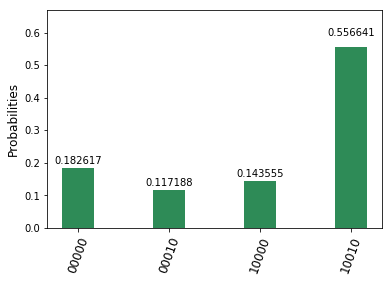

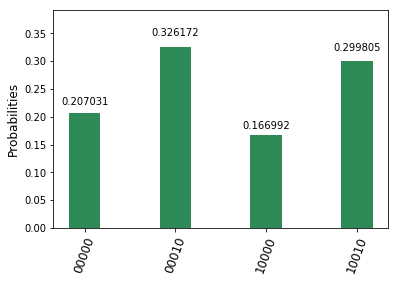

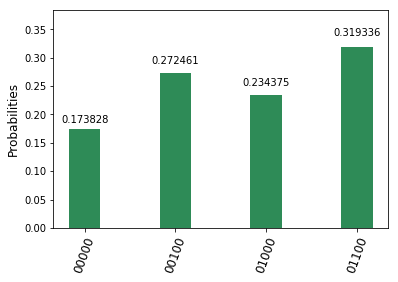

In [142]:
# 3 qubits plus 2 ancillary qubits
n = 5

for val in [0, 1, 2]:
    # Run circuit to detect bit flip error on IBMQ backend
    qp4eb = QuantumProgram()

    # Quantum register
    q = qp4eb.create_quantum_register("q", n)
    # Classical register
    c = qp4eb.create_classical_register("c", n) 

    # SimControl3 circuit
    imbq_err_bit3 = qp4eb.create_circuit("IMBQErrorBit3", [q], [c])

    ## ADD GATES

    # Encode state
    imbq_err_bit3.cx(q[0], q[1]) 
    imbq_err_bit3.cx(q[1], q[2])

    # Introduce bit flip error
    imbq_err_bit3.x(q[val])

    # Error detection
    imbq_err_bit3.cx(q[0], q[3]) 
    imbq_err_bit3.cx(q[1], q[3]) 
    imbq_err_bit3.cx(q[0], q[4]) 
    imbq_err_bit3.cx(q[2], q[4]) 

    # Add measurement operation
    imbq_err_bit3.measure(q[3], c[3])
    imbq_err_bit3.measure(q[4], c[4])

    # Set parameters
    backend = 'ibmqx4'   
    circuits = ['IMBQErrorBit3']  
    shots = 1024           
    max_credits = 3          
    wait = 10   
    timeout = 3600 
    
    # Execute circuit and plot results
    results_bit = qp4eb.execute(circuits, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
    plot_histogram(results_bit.get_counts("IMBQErrorBit3"))

### 8. Run the circuit on the IBMQ backend to and introduce single phase flips.

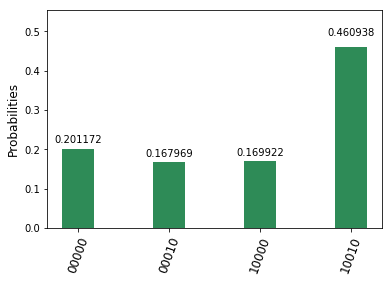

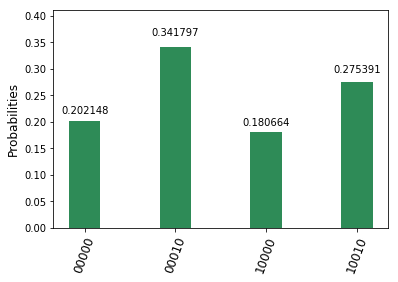

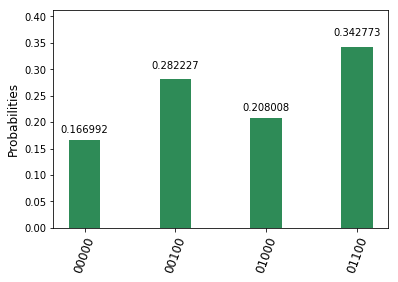

In [149]:
# 3 qubits plus 2 ancillary qubits
n = 5

for val in [0, 1, 2]:
    # Run circuit to detect phase flip error on IBMQ backend
    qp4ep = QuantumProgram()

    # Quantum register
    q = qp4ep.create_quantum_register("q", n)
    # Classical register
    c = qp4ep.create_classical_register("c", n) 

    # IBMQControl4 circuit
    imbq_err_phase3 = qp4ep.create_circuit("IBMQErrorPhase3", [q], [c])

    ## ADD GATES

    # Hadamard basis
    imbq_err_phase3.h(q[0]) 

    # Encode state
    imbq_err_phase3.cx(q[0], q[1]) 
    imbq_err_phase3.cx(q[1], q[2]) 

    # Introduce bit flip error
    imbq_err_phase3.x(q[val])

    # Error detection
    imbq_err_phase3.cx(q[0], q[3]) 
    imbq_err_phase3.cx(q[1], q[3]) 
    imbq_err_phase3.cx(q[0], q[4]) 
    imbq_err_phase3.cx(q[2], q[4]) 

    # Add measurement operation
    imbq_err_phase3.measure(q[3], c[3])
    imbq_err_phase3.measure(q[4], c[4])
      
    # Set parameters
    backend = 'ibmqx4'   
    circuits = ['IBMQErrorPhase3']  
    shots = 1024           
    max_credits = 3          
    wait = 10   
    timeout = 3600 
    
    # Execute circuit and plot results
    results_phase = qp4ep.execute(circuits, backend, shots=shots, max_credits=max_credits, wait=wait, timeout=timeout)
    plot_histogram(results_phase.get_counts("IBMQErrorPhase3"))